In [158]:
from numpy import array, tan, sin, cos, pi, append
from numpy.random import randn
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

V1 = 1.
l = 20.
a = pi/3.
B1 = 1.
w0 = 1.
x0 = V1/w0
y0 = 0
z0 = 0
vx0 = 0
vy0 = -V1
vz0 = -V1/tan(a)
q = 1.
mc = 1.

In [140]:
def f1(xn, yn, zn, vxn, vyn, vzn): #x_{n+1}
    return vxn;

def f2(xn, yn, zn, vxn, vyn, vzn): #y_{n+1}
    return vyn;

def f3(xn, yn, zn, vxn, vyn, vzn): #z_{n+1}
    return vzn;

def f4(xn, yn, zn, vxn, vyn, vzn):
    return (q/mc)*(vyn*B1/4*(3-cos(pi*zn/l)) + (vzn*B1/(8*l))*yn*pi*sin(pi*zn/l)) #Vx_{n+1}

def f5(xn, yn, zn, vxn, vyn, vzn):
    return (q/mc)*(-vxn*B1/4*(3-cos(pi*zn/l)) - (vzn*B1/(8*l))*xn*pi*sin(pi*zn/l)) #Vy_{n+1}

def f6(xn, yn, zn, vxn, vyn, vzn):
    return (q/mc)*((-vxn*B1/(8*l))*yn*pi*sin(pi*zn/l) + (vyn*B1/(8*l))*xn*pi*sin(pi*zn/l)) #Vz_{n+1}

F = [f1, f2, f3, f4, f5, f6]

def rk4(yn):
    k1 = array([f(*yn) for f in F])
    k2 = array([f(*(yn+h/2.*k1)) for f in F])
    k3 = array([f(*(yn+h/2.*k2)) for f in F])
    k4 = array([f(*(yn+h*k3)) for f in F])
    
    return yn + h/6.*(k1 + 2*k2 + 2*k3 + k4)

In [153]:
def getParticleTraectory(N_iter, initial_point, h):
    
    data = list([array(initial_point)])

    for _ in range(N_iter):
        data.append(rk4(data[-1]))

    return array(data).T

In [207]:
random_factor = 0.3
num_particles = 5
particles = [array([x0, y0, z0, vx0, vy0, vz0])+randn(6)*random_factor for _ in range(num_particles)]

In [213]:
N_iter = 400
h = 0.2
red_part = 10

traectories = [getParticleTraectory(N_iter, point, h) for point in particles]

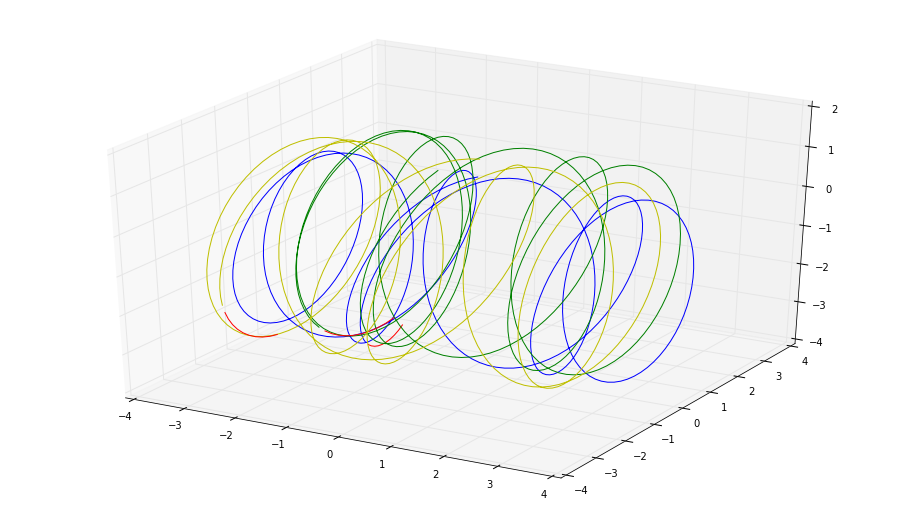

In [217]:
data = traectories[0]
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=data[2][:-red_part], ys=data[1][:-red_part], zs=data[0][:-red_part], c='b')
ax.plot(xs=data[2][-red_part:], ys=data[1][-red_part:], zs=data[0][-red_part:], c='r')

data = traectories[1]
ax.plot(xs=data[2][:-red_part], ys=data[1][:-red_part], zs=data[0][:-red_part], c='g')
ax.plot(xs=data[2][-red_part:], ys=data[1][-red_part:], zs=data[0][-red_part:], c='r')


data = traectories[2]
ax.plot(xs=data[2][:-red_part], ys=data[1][:-red_part], zs=data[0][:-red_part], c='y')
ax.plot(xs=data[2][-red_part:], ys=data[1][-red_part:], zs=data[0][-red_part:], c='r')

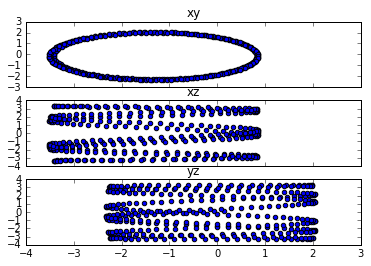

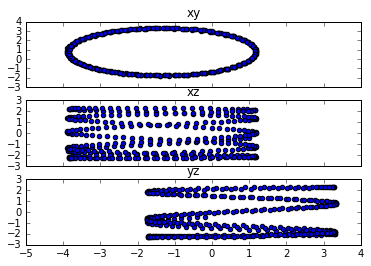

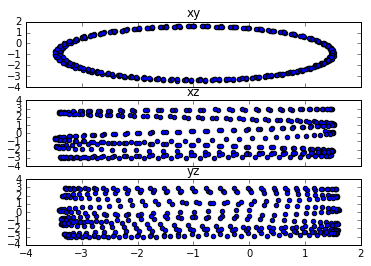

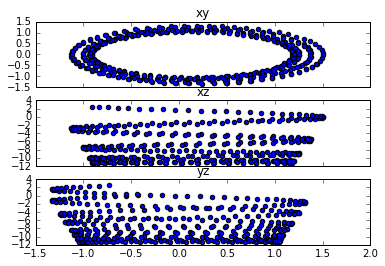

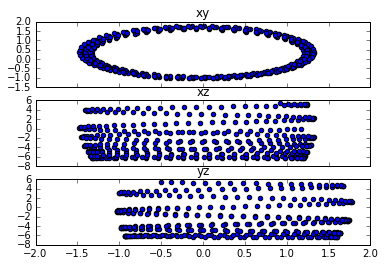

In [215]:
for traectory in traectories:
    f, ax = plt.subplots(3, sharex=True)
    ax[0].scatter(traectory[0], traectory[1])
    ax[0].set_title("xy")
    ax[1].scatter(traectory[0], traectory[2])
    ax[1].set_title("xz")
    ax[2].scatter(traectory[1], traectory[2])
    ax[2].set_title("yz")